# Logarithmic spiral modelling using Bayesian statistics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy.optimize import minimize
import theano
import theano.tensor as tt
from gzbuilderspirals import pa_from_r_theta
from gzbuilderspirals.oo import Pipeline, Arm

In [2]:
plt.style.use('seaborn')

In [3]:
a = Arm.load('lib/spiral_arms/20902040-0.pickle')
arm = Arm(a.get_parent(), a.arms)

In [4]:
t = arm.t
R = arm.R
ls = arm.polar_logsp
gzb_pa = arm.chirality * arm.pa

Non-weighted least squares pitch angle: -12.729˚


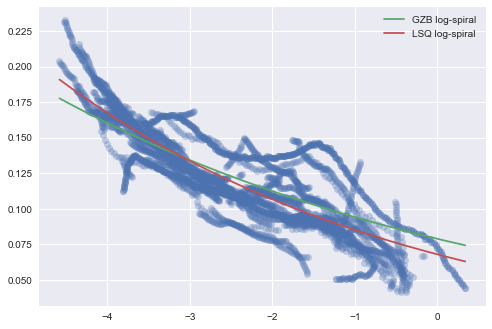

In [5]:
def logsp(t, a, phi):
    b = np.tan(np.deg2rad(phi))
    return a * np.exp(b*t)

def f(p):
    model = logsp(t, *p)
    return np.sum(np.abs(R - model)**2)

res = minimize(
    f,
    (0.1, arm.pa * arm.chirality)
)
plt.plot(t, R, 'o', alpha=0.3)
plt.plot(ls[0], ls[1], label='GZB log-spiral')
plt.plot(ls[0], logsp(ls[0], *res['x']), label='LSQ log-spiral')
plt.legend();
print('Non-weighted least squares pitch angle: {:.3f}˚'.format(res['x'][1]))

TODO: point-weighting

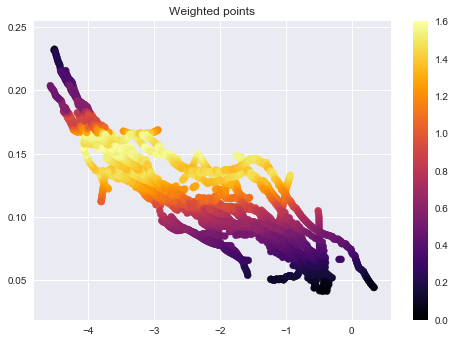

In [11]:
sc = plt.scatter(
    t, R,
    vmin=arm.point_weights.min(),
    vmax=arm.point_weights.max(),
    c=arm.point_weights,
    cmap=plt.cm.get_cmap('inferno'),
)
plt.colorbar(sc)
plt.title('Weighted points');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a, phi]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:19<00:00, 310.77draws/s]


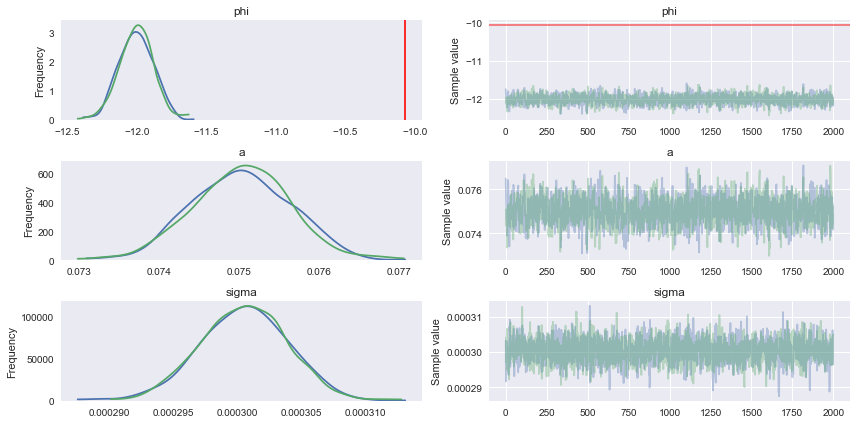

In [7]:
with pm.Model() as model:
    phi = pm.Uniform('phi', lower=-90, upper=90, 
                     testval=arm.chirality * arm.pa)
    a = pm.Uniform('a', lower=0, upper=1)

    mu_r = a * tt.exp(tt.tan(phi * np.pi / 180) * t)
    base_sigma = pm.HalfCauchy('sigma', beta=10, testval=.1)
    sigmas = base_sigma / R**2
    likelihood = pm.Normal('R', mu=mu_r, sd=sigmas, observed=R)

    trace = pm.sample(2000, tune=1000, cores=2)

pm.traceplot(trace, lines={'phi': gzb_pa});

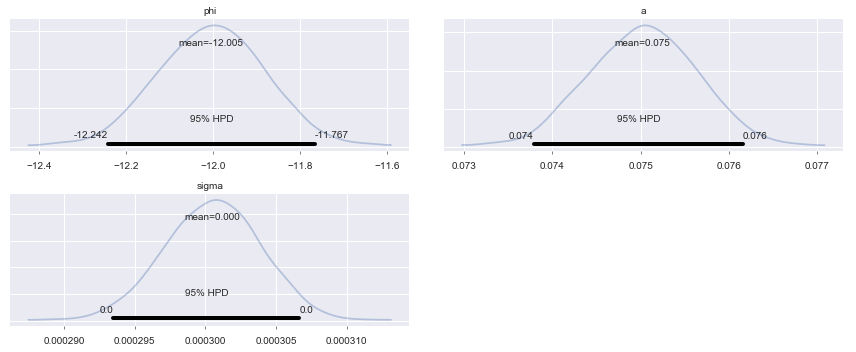

In [8]:
pm.plots.plot_posterior(trace, kde_plot=True);

Pas
	GZB:  -10.07˚ ± 1.603
	PYMC: -12.01˚ ± 0.123


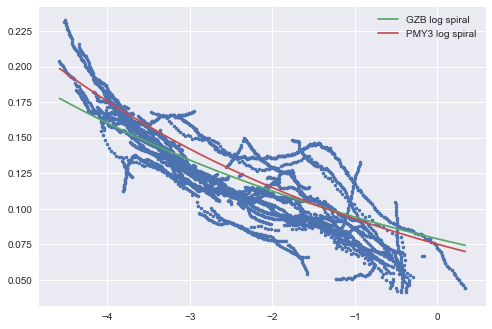

In [9]:
print('Pas')
print('\tGZB:  {:.2f}˚ ± {:.3f}'.format(
    arm.pa * arm.chirality, arm.sigma_pa
))
print('\tPYMC: {:.2f}˚ ± {:.3f}'.format(
    trace['phi'].mean(),
    trace['phi'].std(),
))
plt.plot(t, R, '.')
plt.plot(ls[0], ls[1], label='GZB log spiral')
plt.plot(ls[0], logsp(ls[0], trace['a'].mean(), trace['phi'].mean()),
         label='PMY3 log spiral')
plt.legend();

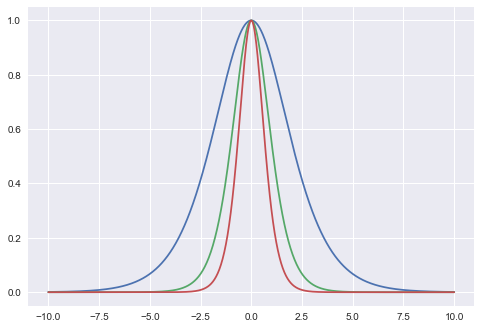

In [10]:
foo = np.linspace(-10, 10, 1000)
for a in (1, 2, 3):
  plt.plot(foo, a*foo / np.sinh(a*foo))